<h1>BoW(Bag-of-Words)-based basic chatbots trained from scratch<h1>

Using the Kaggle dataset:https://www.kaggle.com/datasets/grafstor/simple-dialogs-for-chatbot and the ChatGPT-generated dataset

Example conversation with the Kaggle dataset-trained chatbot:
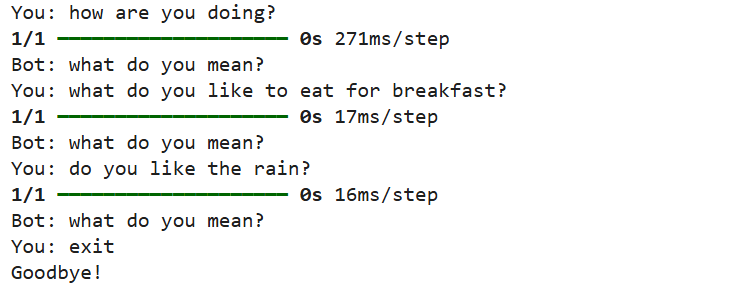

Example conversation with the ChatGPT dataset-trained model:
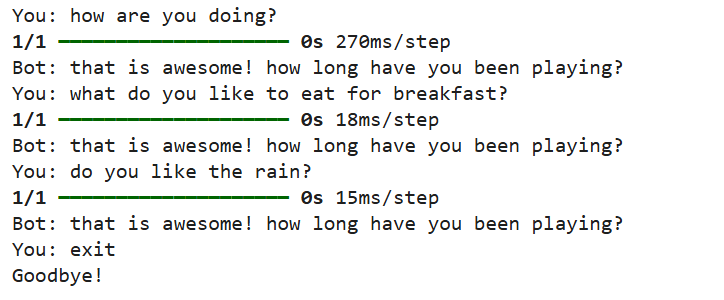


In [ ]:
import numpy as np
import tensorflow as tf
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Download required nltk resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# preparing the Kaggle dataset

data_list = []
my_file_path_kaggle = "my_file_path_to_dataset" # path to the Kaggle dataset, dataset.txt
with open(my_file_path_kaggle, "r") as f:
  data_list = [line.strip("\n") for line in f]

print(f"Loaded {len(data_list)} entries\n")
for i in range(5):
  print(data_list[i])

# making the data cleaner
def uniform_data(data):
  limit = 100

  for i in range(len(data)):
    line = data[i]
    line = line.replace("'ve", " have")
    line = line.replace("'m", " am")
    line = line.replace("'re", " are")
    line = line.replace("'ll", " will")
    line = line.replace("can't", "cannot")
    line = line.replace("n't", " not")
    line = line.replace("i'd", "i would")
    line = line.replace("he's", "he is")
    line = line.replace("it's", "it is")
    line = line.replace("here's", "here is")
    line = line.replace("how's", "how is")
    line = line.replace("who's", "who is")
    line = line.replace("hat's", "hat is")
    line = line.replace("why's", "why is")
    line = line.replace("when's", "when is")
    line = line.replace("everything's", "everything has")
    line = line.replace("something's", "something is")
    line = line.replace("nothing's", "nothing is")
    line = line.replace("someone's", "someone is")
    line = line.replace("'d have", " would have")
    line = line.replace("'d better", " would better")
    line = line.replace("gonna", "going to")
    #line = line.replace("?","") #not sure about the punctuation marks yet
    data[i] = line

    # if len(line.split("\t"))<2 and limit>0:
    #   print(f"{i}. {line}")
    #   limit -= 1
    # for testing - finding parts that are not yet included above
    #exclusions = ["let's","macy's","o'clock"]
    #if (("'" in line) and [(ex in line) for ex in exclusions].count(True) < 1 and limit >= 0):
    #  print(line)
    #  limit -= 1

  return data

data_list = uniform_data(data_list)

def split_data(data):
  prompts, replies = [], []

  for line in data:
    split = line.split("\t")
    if (len(split)<2): # if line doesn't have two columns, report it
      print(line)
    else:
      prompts.append(split[0].strip())
      replies.append(split[1].strip())

  return prompts, replies

prompts, replies = split_data(data_list)

Loaded 3725 entries

hi, how are you doing?	i'm fine. how about yourself?
i'm fine. how about yourself?	i'm pretty good. thanks for asking.
i'm pretty good. thanks for asking.	no problem. so how have you been?
no problem. so how have you been?	i've been great. what about you?
i've been great. what about you?	i've been good. i'm in school right now.


In [ ]:
# Preparing the ChatGPT dataset

data_list2 = []
my_file_path_chatgpt = "my_file_path_to_dataset" # path to the chatGPT-generated dataset, generated_dataset_clean.txt
with open(my_file_path_chatgpt, "r") as f:
  data_list2 = [line.strip("\n") for line in f]

print(f"Loaded {len(data_list2)} entries\n")
for i in range(5):
  print(data_list2[i])
print()

data_list2 = uniform_data(data_list2)

prompts2, replies2 = split_data(data_list2)

Loaded 1611 entries

how have you been feeling lately?	i'm doing pretty well, just a little tired from work.
are you getting enough sleep these days?	not really, but i'm trying to go to bed earlier.
you seem really energized today!	thanks, i started doing morning yoga, and it's helping a lot.
have you been drinking enough water?	probably not, i always forget to refill my bottle.
you've been working so hard lately. are you taking breaks?	i try to, but sometimes it's hard to step away.



In [ ]:
# Extract the questions and answers from the dataset
#questions = prompts # Choose the dataset accordingly, the first two lines use the Kaggle dataset, the other two use the ChatGPT dataset
#answers = replies
questions = prompts2
answers = replies2

In [ ]:
# Tokenize and preprocess the questions
words = []
for question in questions:
    word_list = nltk.word_tokenize(question)  # Tokenizing each word in the question
    words.extend(word_list)
words = [lemmatizer.lemmatize(w.lower()) for w in words]
words = sorted(list(set(words)))  # Remove duplicates

# Prepare the training data
X_train = []
y_train = []

for i, question in enumerate(questions):
    # Create a bag of words for each question
    word_list = nltk.word_tokenize(question)
    word_list = [lemmatizer.lemmatize(w.lower()) for w in word_list]
    bag = [0] * len(words)
    for w in word_list:
        for j, word in enumerate(words):
            if word == w:
                bag[j] = 1
    X_train.append(bag)
    y_train.append(answers[i])

X_train = np.array(X_train)

# Convert answers into a numeric representation
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

# Define the model
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(y_train)), activation='softmax'))  # Output layer with size of unique answers

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
model.fit(X_train, np.array(y_train), epochs=200, batch_size=8, verbose=1)

# Function to get the chatbot response
def chatbot_response(text):
    # Convert the input into a bag of words representation
    words_input = nltk.word_tokenize(text)
    words_input = [lemmatizer.lemmatize(w.lower()) for w in words_input]
    bag = [0] * len(words)
    for w in words_input:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1

    # Predict the response
    prediction = model.predict(np.array([bag]))[0]
    predicted_index = np.argmax(prediction)
    predicted_answer = encoder.inverse_transform([predicted_index])[0]

    return predicted_answer

# Testing the chatbot
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break
    response = chatbot_response(user_input)
    print("Bot: " + response)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0000e+00 - loss: 7.5319
Epoch 2/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0000e+00 - loss: 7.5101
Epoch 3/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 7.5002
Epoch 4/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 7.4578
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.3555e-04 - loss: 7.4425
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 7.4412
Epoch 7/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0015 - loss: 7.4224
Epoch 8/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0016 - loss: 7.4360
Epoch 9/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 3.9905e-04 - loss: 7.4350
Epoch 10/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0015 - loss: 7.4135
Epoch 11/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0024 - loss: 7.4051
Epoch 12/200